# 규제 선형 모델 - 릿지, 라쏘, 엘라스틱 넷
- 선형 모델의 비용함수는 RSS를 최소화하는, 즉 실제 값과 예측값의 차이를 최소화하는 것만 고려하였음
- 학습 데이터에 지나치게 fit하여 회귀 계수가 쉽게 커져 오히려 테스트 데이터 세트의 예측 성능이 저하
- 비용함수는 학습 데이터의 잔차 오류 값을 최소로 하는 RSS 최소화 방법과 과적합을 방지하기 위해 회귀 계수 값이 커지지 않도록 하는 방법이 서로 균형이 이뤄야 함
- 회귀 계수의 크기를 제어하는 비용함수의 목표:
$$Min(RSS(W) + alpha*\lVert w \rVert_2^2)$$
- alpha: 학습 데이터 적합 정도와 회귀 계수 값의 크기 제어를 수행하는 튜닝 파라미터
- $RSS(W) + alpha*\lVert w \rVert_2^2$를 최소화하는 W벡터를 도출해야 함
- alpha 값을 크게 하면 비용 함수는 회귀 계수 W의 값을 작게 해 과적합을 개선할 수 있다.
- alpha 값을 작게 하면 회귀 계수 W의 값이 커져도 어느정도 상쇄가 가능하므로 학습 데이터 적합을 더 개선할 수 있음
    - alpha = 0: w가 커도 alpha $*\lVert w \rVert_2^2$가 0이 되어 비용함수는 Min(RSS(W))
    - alpha = $\infty$: alpha $*\lVert w \rVert_2^2$도 무한대가 되므로 비용 함수는 W는 0에 가깝게 최소화 해야 함.
- 이처럼 비용 함수에 alpha 값으로 페널티를 부여해 회귀 계수 값의 크기를 감소시켜 과적합을 개선하는 방식을 규제(Regularization)이라고 함
- 규제는 크게 L2 방식과 L1 방식으로 구분
    - L2 규제는 $alpha * \lVert w \rVert_2^2$와 같이 W의 제곱에 대해 페널티를 부여하는 방식 -> 릿지(Ridge)회귀
    - L1 규제는 $alpha * \lVert w \rVert_1$와 같이 W의 절댓값에 대해 페널티를 부여하는 방식 -> 라쏘(Lasso)회귀
        - 영향력이 크지 않은 회귀 계수 값을 0으로 변환

# 릿지 회귀
- 사이킷런의 Ridge 클래스를 통해 구현 가능
- 주요 생성 파라미터는 alpha이며 이는 릿지 회귀의 alpha L2규제 계수

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn-whitegrid'])
from scipy import stats
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score
%matplotlib inline

# boston 데이터 세트 로드
boston = load_boston()

# boston 데이터 세트 DataFrame 변환
bostonDF = pd.DataFrame(boston.data, columns=boston.feature_names)

# boston 데이터 세트의 target 배열은 주택가격임. 이를 PRICE 컬럼을 DataFrame으로 추가함
bostonDF['PRICE']=boston.target

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge

# alpha=10으로 설정해 릿지 회귀 수행
ridge = Ridge(alpha=10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print(' 5 fold 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 3))
print(' 5 fold 의 개별 RMSE scores: ', np.round(rmse_scores, 3))
print(' 5 fold 의 평균 RMSE: {0:.3f}'.format(avg_rmse))

 5 fold 의 개별 Negative MSE scores:  [-11.422 -24.294 -28.144 -74.599 -28.517]
 5 fold 의 개별 RMSE scores:  [3.38  4.929 5.305 8.637 5.34 ]
 5 fold 의 평균 RMSE: 5.518


> alpha의 값을 변화하면서 RMSE 값과 각 피처의 회귀 계수를 시각화하고 DataFrame에 저장하는 예제

In [3]:
# 릿지에 사용될 alpha 파라미터의 값을 정의
alphas =[0, 0.1, 1, 10, 100]

# alphas list 값을 반복하면서 alpha에 따른 평균 rmse를 구함
for alpha in alphas:
    ridge = Ridge(alpha = alpha)
    
    # cross_val_score를 이용해 5 폴드의 평균 RMSE를 계산
    neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv=5)
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0} 일 때 5 folds의 평균 RMSE: {1:.3f}'.format(alpha, avg_rmse))

alpha 0 일 때 5 folds의 평균 RMSE: 5.829
alpha 0.1 일 때 5 folds의 평균 RMSE: 5.788
alpha 1 일 때 5 folds의 평균 RMSE: 5.653
alpha 10 일 때 5 folds의 평균 RMSE: 5.518
alpha 100 일 때 5 folds의 평균 RMSE: 5.330


회귀 계수를 Ridge 객체의 coef_ 속성에 추출한 뒤에 Series 객체로 만들어서 seaborn 가로 막대 차트로 표시하고, DataFrame에 alpha 값별 회귀 계수를 저장

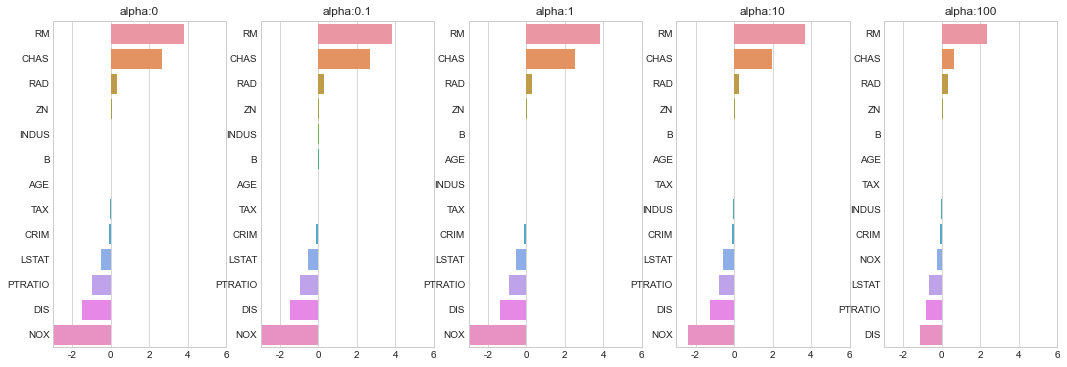

In [4]:
# 각 alpha에 따른 회귀 계수 값을 시각화하기 위해 5개의 열로 된 matplotlib 축 생성
fig, axs = plt.subplots(figsize=(18, 6), nrows=1, ncols=5)
# 각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 DataFrame 생성
coeff_df = pd.DataFrame()

# alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장. pos는 aics의 위치 지정
for pos, alpha in enumerate(alphas):
    ridge = Ridge(alpha = alpha)
    ridge.fit(X_data, y_target)
    # alpha에 따른 피처별로 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가
    coeff = pd.Series(data=ridge.coef_, index=X_data.columns)
    colname='alpha:'+str(alpha)
    coeff_df[colname]=coeff
    # 막대 그래프로 각 alpha 값에서의 회귀 계수를 시각화. 회귀 계수값이 높은 순으로 표현
    coeff = coeff.sort_values(ascending=False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3, 6)
    sns.barplot(x=coeff.values, y=coeff.index, ax=axs[pos])
    
# for 문 바깥에서 matplotlib의 show 호출 및 alpha에 따른 피처별 회귀 계수를 DataFrame으로 표시
plt.show()

In [5]:
ridge_alphas = [0, 0.1, 1, 10, 100]
sort_column = 'alpha:'+str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column, ascending=False)

,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


- alpha 값을 계속 증가시킬수록 회귀 계수 값은 지속적으로 작아지고 있음
- 특히 NOX 피처의 경우 -17에서 -0.2까지 감소하였음
- 하지만 릿지회귀의 경우 회귀 계수를 0으로 만들지는 않음

# 라쏘 회귀
- W의 절댓값에 페널티를 부여하는 L1 규제를 선형 회귀에 적용한 것이 라쏘(Lasso) 회귀
- 즉 L1 규제는 $alpha * \lVert w \rVert_1$를 의미하며, 라쏘 회귀 비용함수의 목표는 $RSS(W) + alpha* \lVert w \rVert_1$ 식을 최소화하는 W를 찾는 것
- L2 규제가 회귀 계수의 크기를 감소시키는 데 반해, L1 규제는 불필요한 회귀 계수를 급격하게 감소시켜 0으로 만들고 제거함
- 이러한 측면에서 L1 규제는 적절한 피처만 회귀에 포함시키는 피처 선택의 특성을 가지고 있음

- 사이킷런은 Lasso 클래스를 통해 라쏘 회귀를 구현
- Lasso 클래스의 주요 생성 파라미터는 alpha이며, 이는 라쏘 회귀의 alpha L1 규제 계수에 해당함
> 라쏘의 alpha 값을 변화시키면서 RMSE와 각 피처의 회귀 계수를 출력하기
- get_linear_reg_eval( )는 인자로 회귀 모델의 이름, alpha 값들의 리스트, 피처 데이터 세트와 타깃 데이터 세트를 입력 받아서 alpha 값에 따른 폴드 평균 RMSE를 출력하고 회귀 계수값들을 DataFrame으로 반환.

In [6]:
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures

# alpha 값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고 회귀 계수값들을 DataFrame으로 반환
def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None, 
                        verbose=True, return_coeff=True):
    coeff_df = pd.DataFrame()
    if verbose: print('####### ', model_name, '#######')
    for param in params:
        if model_name == 'Ridge': model=Ridge(alpha=param)
        elif model_name == 'Lasso': model=Lasso(alpha=param)
        elif model_name == 'ElasticNet': model=ElasticNet(alpha=param, l1_ratio=0.7)
        neg_mse_scores = cross_val_score(model, X_data_n,
                                         y_target_n, scoring="neg_mean_squared_error", cv=5)
        avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
        print('alpha {0}일 때 5 폴드 세트의 평균 RMSE: {1:.3f}'.format(param, avg_rmse))
        # cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출
        
        model.fit(X_data_n, y_target_n)
        if return_coeff:
            # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가.
            coeff = pd.Series(data=model.coef_, index=X_data_n.columns)
            colname = 'alpha:'+str(param)
            coeff_df[colname] = coeff
    
    return coeff_df
# end of get_linear_regre_eval

In [7]:
# 라쏘에 사용될 alpha 파라미터의 값을 정의하고 get_linear_reg_eval() 함수 호출
lasso_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df = get_linear_reg_eval('Lasso', params=lasso_alphas, X_data_n=X_data, y_target_n=y_target)

#######  Lasso #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.612
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.615
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.669
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.776
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.189


In [8]:
# 반환된 coeff_lasso_df를 첫 번째 칼럼 순으로 내림차순 정렬해 회귀 계수 DataFrame으로 출력
sort_column = 'alpha:'+str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.789725,3.703202,2.498212,0.949811,0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
B,0.010248,0.010249,0.009469,0.008247,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000


- alpha의 크기가 증가함에 따라 일부 피처의 회귀 계수는 아예 0으로 바뀌고 있음
- 회귀 계수가 0인 피처는 회귀 식에서 제외되면서 피처 선택의 효과를 얻을 수 있음

# 엘라스틱넷 회귀
- 엘라스틱넷(Elastic Net) 회귀는 L2규제와 L1규제를 결합한 회귀
- 엘라스틱넷 회귀 비용함수의 목표는 $RSS(W) + alpha2*\lVert w \rVert_2^2 + alpha1*\lVert w \rVert_1$식을 최소화하는 W를 찾는 것
- 엘라스틱넷은 라쏘 회귀가 서로 상관관계가 높은 피처들의 경우에 이들 중에서 중요 피처만을 셀렉션하고 다른 피처들은 모두 회귀 계수를 0으로 만드는 성향이 강함
- 특히 이러한 성향으로 인해 alpha값에 따라 회귀 계수의 값이 급력히 변동할 수 있는데, 엘라스틱넷 회귀는 이를 완화하기 위해 L2규제를 라쏘 회귀에 추가한 것
- 반대로 엘라스틱넷 회귀의 단점은 L1과 L2 규제가 결합된 규제로 인해 수행히간이 상대적으로 오래 걸린다는 점
<br>

- ElasticNet의 파라미터
    - alpha: 엘라스틱넷의 규제는 a * L1 + b * L2로 정의될 수 있으며, 이 때 a는 L1 규제의 alpha 값, b는 L2 규제의 alpha 값  
    따라서 ElasticNet 클래스의 alpha 파라미터 값은 a+b
    - l1_ratio: l1_ratio 파라미터 값은 a / (a + b).  
    l1_ratio가 0이면 a가 0이므로 L2 규제와 동일함.  
    l1_ratio가 1이면 b가 0이므로 L1 규제와 동일

> 엘라스틱넷 alpha 값을 변화시키면서 RMSE와 각 피처의 회귀 계수를 출력

In [9]:
# 엘라스틱넷에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval( ) 함수 호출
# l1_ratio는 0.7로 고정
elastic_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df = get_linear_reg_eval('ElasticNet', params = elastic_alphas,
                                       X_data_n=X_data, y_target_n=y_target)

#######  ElasticNet #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.542
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.526
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.467
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.597
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.068


In [10]:
# 반환된 coeff_elastic_df를 첫번째 칼럼순으로 내림차순 정렬해 회귀 계수 DataFrame 출력
sort_column = 'alpha:'+str(elastic_alphas[0])
coeff_elastic_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


# 선형 회귀 모델을 위한 데이터 변환
- 선형 회귀 모델은 피처값과 티깃값의 분포가 정규 분포 (즉 평균을 중심으로 종 모양으로 데이터 값이 분포된 형태)를 선호함
- 특히 타깃값이 특정값의 분포가 치우친 왜곡(Skew)된 형태의 분포도일 경우 예측 성능에 부정적인 영향을 미칠 가능성이 높음  
$\rightarrow$ 피처값 역시 왜곡된 분포가 예측성능을 낮춤(타깃보다는 덜 심함)
- 따라서 선형회귀 모델을 적용하기 전에 데이터에 대한 스케일링/정규화 작업을 수행하는 것이 일반적
- 피처 데이터 세트와 타깃 데이터 세트에 스케일링/정규화 작업을 수행하는 방법은 조금 다름
<br>

- 피처 데이터 세트에 적용하는 변환 작업
    1. StandardScaler 클래스를 이용해 평균이 0, 분산이 1인 표준 정규 분포를 가진 데이터 세트로 변환하거나  
    MinMaxScaler 클래스를 이용해 최솟값이 0이고  최댓값이 1인 값으로 정규화 수행
    2. 스케일링/정규화를 수행한 데이터 세트에 다시 다항 특성을 적용하여 변환  
    보통 1번 방법을 통해 예측 성능에 향상이 없을 경우 수행
    3. 원래 값에 log 함수를 적용하면 보다 정규 분포에 가까운 형태로 값이 분포 $\rightarrow$ 로그 변환(Log Transformation)  
    1, 2번 방법보다 훨씬 많이 사용되는 변환 방법  
    1번 방법의 경우 예측 성능 향상이 크지 않을 가능성이 높고  
    2번 방법의 경우 피처의 개수가 매우 많을 경우에는 다항 변환으로 생성되는 피처의 개수가 기하급수로 늘어나서 과적합의 이슈가 발생하기 때문
    
<br>    

- 타깃 값의 경우 일반적으로 로그변환을 적용
- 결정 값을 정규 분포나 다른 정규값으로 변환하면 변환된 값을 다시 원본 타깃값으로 원복하기 어려움
- 무엇보다도, 왜곡된 분포도 형태의 타깃값을 로그 변환하여 예측 성능 향상이 된 경우가 많은 사례로 검증
> 보스턴 주택가격 피처 데이터 세트에 표준 정규분포 변환, MinMaxScaler, 로그 변환을 적용하여 RMSE로 예측 성능을 측정하는 예제
    - get_scaled_data( ): method 인자로 변환 방법을 결정하며 표준정규분포 변환, 최댓값/최솟값 정규화 로그변환 중 하나를 선택함
    - np.log( )함수를 적용하면 언더 플로우가 발생하기 쉬우므로 np.log1p( )를 이용

In [11]:
# method는 표준 정규 분포 변환(Standard), 최댓값/최솟값 정규화(MinMax), 로그 변환(Log) 결정
# p_degree는 다항식 특성을 추가할 때 적용. p_degree는 2이상 부여하지 않음
def get_scaled_data(method='None', p_degree=None, input_data=None):
    if method == 'Standard':
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method == 'MinMax':
        scaled_data = MinMaxScaler().fit_transform(input_data)
    elif method == 'Log':
        scaled_data = np.log1p(input_data)
    else:
        scaled_data = input_data
            
    if p_degree != None:
        scaled_data = PolynomialFeatures(degree=p_degree, 
                                         include_bias=False).fit_transform(scaled_data)
        
    return scaled_data

In [14]:
# Ridge의 alpha 값을 다르게 적용하고 다양한 데이터 변환 방법에 따른 RMSE 추출
alphas = [0.1, 1, 10, 100]

# 5개의 방식으로 변환. 먼저 원본 그대로, 표준정규 분포, 표준정규 분포 + 다항식 특성
# 최대/최소 정규화, 최대/최소 정규화 + 다항식 특성, 로그 변환
scale_methods = [(None, None), ('Standard', None), ('Standard', 2),
                 ('MinMax', None), ('MinMax', 2), ('Log', None)]

for scale_method in scale_methods:
    X_data_scaled = get_scaled_data(method=scale_method[0], p_degree=scale_method[1],
                                    input_data=X_data)
    print('\n## 변환 유형:{0}, Polynomial Degree: {1}'.format(scale_method[0], scale_method[1]))
    get_linear_reg_eval('Ridge', params=alphas, X_data_n=X_data_scaled,
                        y_target_n=y_target, verbose=False, return_coeff=False)


## 변환 유형:None, Polynomial Degree: None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.788
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.653
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.518
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.330

## 변환 유형:Standard, Polynomial Degree: None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.826
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.803
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.637
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.421

## 변환 유형:Standard, Polynomial Degree: 2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 8.827
alpha 1일 때 5 폴드 세트의 평균 RMSE: 6.871
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.485
alpha 100일 때 5 폴드 세트의 평균 RMSE: 4.634

## 변환 유형:MinMax, Polynomial Degree: None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.764
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.465
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.754
alpha 100일 때 5 폴드 세트의 평균 RMSE: 7.635

## 변환 유형:MinMax, Polynomial Degree: 2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.298
alpha 1일 때 5 폴드 세트의 평균 RMSE: 4.323
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.185
alpha 100일 때 5 폴드 세트의 평균 RMSE: 6.538

## 변환 유형:Log, Polynomial Degree: None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE:

- 표준 정규와 최솟값/최댓값 정규화로 피처 데이터 세트를 변경해도 성능상의 개선이 별로 없음
- 표준 정규 분포로 일차 변환 후 2차 다항식 변환을 했을 때 alpha=100에서 성능이 4.634로 개선됌
- 로그 변환을 보면 alpha에 무엇이 들어가든 성능이 좋아졌음